In [1]:
from pathlib import Path

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

from PIL import Image
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

import itertools 

2023-05-11 12:46:14.149298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Importer le DataFrame
df = pd.read_csv("V2_Plant_Seedlings_DataFrame.csv", sep=';')
df.head()

,filepath,species,image_name,height,width,R_mean,G_mean,B_mean,luminosity,blur_score,image_size,sharpness_score,square
0,/Users/thithaotrucle/Documents/Projet fil roug...,Black-grass,1.png,138,138,105.075247,98.336957,89.631590,97.681264,151.874492,19044,8.365028,square
1,/Users/thithaotrucle/Documents/Projet fil roug...,Black-grass,10.png,1040,1040,79.711614,68.709711,60.161677,69.527667,133.348355,1081600,367.182903,square
2,/Users/thithaotrucle/Documents/Projet fil roug...,Black-grass,100.png,82,82,111.598602,103.431440,92.232302,102.420781,131.975238,6724,2.803053,square
3,/Users/thithaotrucle/Documents/Projet fil roug...,Black-grass,101.png,156,156,84.529668,67.176446,48.901833,66.869316,132.849602,24336,8.426078,square
4,/Users/thithaotrucle/Documents/Projet fil roug...,Black-grass,102.png,197,197,88.982092,72.174805,53.490505,71.549134,108.609648,38809,12.779936,square


In [3]:
# Train/test split
train_df,test_df = train_test_split(df,
                                    test_size=0.2,
                                    random_state=3,
                                    shuffle=True,
                                    stratify=df['species'])

In [5]:
# Paramètres de preprocessing
color_mode = 'rgb'
target_size = (224,224)
channels = 3
batch_size = 32

In [6]:
# Instanciation du générateur de données
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                          rotation_range=90,
                                          width_shift_range=0.05, 
                                          height_shift_range=0.05,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          validation_split=0.2)

test_data_generator = ImageDataGenerator(rescale = 1./255)

In [7]:
# Instanciation des itérateurs
train_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                           x_col='filepath',
                                                           y_col='species',
                                                           target_size=target_size,
                                                           color_mode=color_mode,
                                                           class_mode='sparse',
                                                           batch_size=batch_size,
                                                           subset="training")
validation_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                               x_col='filepath',
                                                               y_col='species',
                                                               target_size=target_size,
                                                               color_mode=color_mode,
                                                               class_mode='sparse',
                                                               batch_size=batch_size,
                                                               subset="validation")

test_iterator = test_data_generator.flow_from_dataframe(test_df,
                                                         x_col='filepath',
                                                         y_col='species',
                                                         target_size=target_size,
                                                         color_mode=color_mode,
                                                         class_mode='sparse',
                                                         batch_size=batch_size,
                                                         shuffle=False)


Found 3545 validated image filenames belonging to 12 classes.
Found 886 validated image filenames belonging to 12 classes.
Found 1108 validated image filenames belonging to 12 classes.


In [8]:
# Transfer learning sur la base du modèle MobileNetV2

# Etape 1: Entraînement avec les poids du modèle MobileNetV2 pré-entraîné sur la base ImageNet

# Chargement du modèle de base pré-entraîné
base_model = MobileNetV2(include_top = False,
                        weights = 'imagenet',
                        pooling='avg')
base_model.summary()

# Freeze des poids du modèle de base
for layer in base_model.layers:
    layer.trainable = False    

2023-05-11 12:46:27.714988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

                                                                                                  
 block_3_expand (Conv2D)        (None, None, None,   3456        ['block_2_add[0][0]']            
                                144)                                                              
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, None, None,   576        ['block_3_expand[0][0]']         
 ization)                       144)                                                              
                                                                                                  
 block_3_expand_relu (ReLU)     (None, None, None,   0           ['block_3_expand_BN[0][0]']      
                                144)                                                              
                                                                                                  
 block_3_p

                                192)                                                              
                                                                                                  
 block_6_expand_BN (BatchNormal  (None, None, None,   768        ['block_6_expand[0][0]']         
 ization)                       192)                                                              
                                                                                                  
 block_6_expand_relu (ReLU)     (None, None, None,   0           ['block_6_expand_BN[0][0]']      
                                192)                                                              
                                                                                                  
 block_6_pad (ZeroPadding2D)    (None, None, None,   0           ['block_6_expand_relu[0][0]']    
                                192)                                                              
          

 block_9_expand_BN (BatchNormal  (None, None, None,   1536       ['block_9_expand[0][0]']         
 ization)                       384)                                                              
                                                                                                  
 block_9_expand_relu (ReLU)     (None, None, None,   0           ['block_9_expand_BN[0][0]']      
                                384)                                                              
                                                                                                  
 block_9_depthwise (DepthwiseCo  (None, None, None,   3456       ['block_9_expand_relu[0][0]']    
 nv2D)                          384)                                                              
                                                                                                  
 block_9_depthwise_BN (BatchNor  (None, None, None,   1536       ['block_9_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_12_depthwise (DepthwiseC  (None, None, None,   5184       ['block_12_expand_relu[0][0]']   
 onv2D)                         576)                                                              
                                                                                                  
 block_12_depthwise_BN (BatchNo  (None, None, None,   2304       ['block_12_depthwise[0][0]']     
 rmalization)                   576)                                                              
                                                                                                  
 block_12_depthwise_relu (ReLU)  (None, None, None,   0          ['block_12_depthwise_BN[0][0]']  
                                576)                                                              
                                                                                                  
 block_12_

 onv2D)                         960)                                                              
                                                                                                  
 block_15_depthwise_BN (BatchNo  (None, None, None,   3840       ['block_15_depthwise[0][0]']     
 rmalization)                   960)                                                              
                                                                                                  
 block_15_depthwise_relu (ReLU)  (None, None, None,   0          ['block_15_depthwise_BN[0][0]']  
                                960)                                                              
                                                                                                  
 block_15_project (Conv2D)      (None, None, None,   153600      ['block_15_depthwise_relu[0][0]']
                                160)                                                              
          

In [9]:
# Création du modèle complet: construction fonctionnelle

inputs = Input(shape=(target_size[0],target_size[1],channels),name='Input')
          
# Définition des couches de classification
classif_layer1 = Dropout(rate=0.2,name='Dropout_layer_1')
classif_layer2 = Dense(units=256,activation='relu',name='Dense_layer_1')
classif_layer3 = Dropout(rate=0.2,name='Dropout_layer_2')
classif_layer4 = Dense(units=128,activation='relu',name='Dense_layer_2')
classif_layer5 = Dropout(rate=0.2,name='Dropout_layer_3')
output_layer = Dense(units=12,activation='softmax',name='Dense_layer_output')

# Assemblage du modèle
x = base_model(inputs)
x = classif_layer1(x)
x = classif_layer2(x)
x = classif_layer3(x)
x = classif_layer4(x)
x = classif_layer5(x)
outputs = output_layer(x)

model = Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 Dropout_layer_1 (Dropout)   (None, 1280)              0         
                                                                 
 Dense_layer_1 (Dense)       (None, 256)               327936    
                                                                 
 Dropout_layer_2 (Dropout)   (None, 256)               0         
                                                                 
 Dense_layer_2 (Dense)       (None, 128)               32896     
                                                             

In [10]:
# Définition des callbacks EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0.01,
                               mode='max',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                         factor=0.5,
                                         min_delta=0.01,
                                         mode='max',
                                         patience=3,
                                         verbose=1)


# Définition d'un callback mesurant la durée de l'entraînement 
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_train_begin(self, logs={}):
        self.starttime = timer()
    def on_train_end(self, logs={}):
        self.logs.append(timer()-self.starttime)

time_callback = TimingCallback()

In [11]:
# Fonction permettant de charger un éventuel modèle précédemment entraîné, de compiler et de lancer l'entraînement

def model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=None,lr=1.e-3,nb_epochs=30):
    
    # Chargement des poids obtenus lors d'un précédent entraînement
    if loadweights_filepath != None:
        model.load_weights(loadweights_filepath)
        
    # Compilation
    model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics='accuracy')
    
    # Définition du ModelCheckPoint
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       verbose=1)
    
    # Définition du CSV Logger (enregistrement de l'historique d'entraînement)
    csv_logger = CSVLogger(csvlogger_filepath,append=True)
    
    # Entraînement
    training_history = model.fit(train_iterator,validation_data=validation_iterator,
                                 epochs=nb_epochs,
                                 steps_per_epoch=train_iterator.samples//batch_size,
                                 validation_steps=validation_iterator.samples//batch_size,
                                 callbacks=[time_callback,reduce_learning_rate,model_checkpoint,csv_logger],
                                 verbose=True)


In [12]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom','Freeze','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom','Freeze','training_history.csv')

In [13]:
# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 1.6816 - accuracy: 0.4170
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to Models_training/MobileNetV2_SansSeg_SansZoom/Freeze/best_weights.ckpt
110/110 [==============================] - 86s 770ms/step - loss: 1.6816 - accuracy: 0.4170 - val_loss: 1.0385 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 1.1504 - accuracy: 0.5915
Epoch 2: val_accuracy improved from 0.66667 to 0.71759, saving model to Models_training/MobileNetV2_SansSeg_SansZoom/Freeze/best_weights.ckpt
110/110 [==============================] - 86s 783ms/step - loss: 1.1504 - accuracy: 0.5915 - val_loss: 0.7919 - val_accuracy: 0.7176 - lr: 0.0010
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.9884 - accuracy: 0.6405
Epoch 3: val_accuracy improved from 0.71759 to 0.77315, saving model to Models_training/MobileNetV2_SansSeg_SansZoom/Freeze/best_weights.

Epoch 24/30
110/110 [==============================] - ETA: 0s - loss: 0.5317 - accuracy: 0.8053
Epoch 24: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 24: val_accuracy did not improve from 0.83681
110/110 [==============================] - 80s 730ms/step - loss: 0.5317 - accuracy: 0.8053 - val_loss: 0.4666 - val_accuracy: 0.8218 - lr: 6.2500e-05
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.4859 - accuracy: 0.8278
Epoch 25: val_accuracy improved from 0.83681 to 0.84028, saving model to Models_training/MobileNetV2_SansSeg_SansZoom/Freeze/best_weights.ckpt
110/110 [==============================] - 80s 731ms/step - loss: 0.4859 - accuracy: 0.8278 - val_loss: 0.4651 - val_accuracy: 0.8403 - lr: 3.1250e-05
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.5024 - accuracy: 0.8101
Epoch 26: val_accuracy did not improve from 0.84028
110/110 [==============================] - 80s 731ms/step - loss: 0.5024 - accurac

In [14]:
# Calcul de la durée de l'entrainement
print("Durée de l'entraînement:",time_callback.logs[0]//60,"minutes.")

Durée de l'entraînement: 40.0 minutes.


In [39]:
# Résultats de l'entrainement 
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head(30)

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.417022,1.681602,0.001000,0.666667,1.038466
1,0.591517,1.150426,0.001000,0.717593,0.791940
2,0.640478,0.988421,0.001000,0.773148,0.702615
3,0.691716,0.851848,0.001000,0.746528,0.685348
4,0.705665,0.832985,0.001000,0.782407,0.652447
5,0.719613,0.781959,0.001000,0.780093,0.610188
6,0.735554,0.727091,0.000500,0.797454,0.579324
7,0.758896,0.670253,0.000500,0.790509,0.557696
8,0.754910,0.671925,0.000500,0.814815,0.539691


In [38]:
# Trouve l'index de la ligne avec la valeur maximale de val_accuracy
max_val_accuracy_idx = training_history['val_accuracy'].idxmax()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_max_val_accuracy = training_history.loc[max_val_accuracy_idx]
print('Valeurs Max')
print(row_with_max_val_accuracy)

# Trouve l'index de la ligne avec la valeur min de val_accuracy
min_val_accuracy_idx = training_history['val_accuracy'].idxmin()

# Sélectionne la ligne correspondante et affiche toutes les colonnes
row_with_min_val_accuracy = training_history.loc[min_val_accuracy_idx]
print('Valeurs Min')
print(row_with_min_val_accuracy)

column_means = training_history.mean()
print('Valeurs Moyennes')
print(column_means)

Valeurs Max
accuracy        0.815542
loss            0.502114
lr              0.000016
val_accuracy    0.843750
val_loss        0.441424
Name: 27, dtype: float64
Valeurs Min
accuracy        0.417022
loss            1.681602
lr              0.001000
val_accuracy    0.666667
val_loss        1.038466
Name: 0, dtype: float64
Valeurs Moyennes
accuracy        0.763981
loss            0.657653
lr              0.000373
val_accuracy    0.806211
val_loss        0.546243
dtype: float64


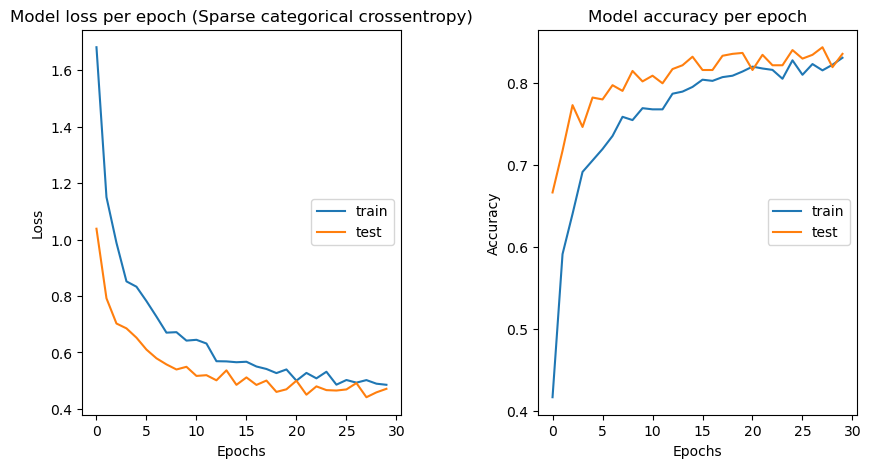

In [16]:
# Courbes de précisions et de pertes par epoch pour train et test
train_loss = training_history['loss']
val_loss = training_history['val_loss']

train_acc = training_history['accuracy']
val_acc = training_history['val_accuracy']

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss per epoch (Sparse categorical crossentropy)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='right')

plt.subplots_adjust(wspace=0.43);


In [17]:
model.load_weights(checkpoint_filepath)

In [30]:
#Prédictions du classifieur
y_pred_test = model.predict(test_iterator)
y_pred_train = model.predict(train_iterator) #option
test_pred_class = y_pred_test.argmax(axis=1)
y_test = test_iterator.classes


111/111 [==============================] - 68s 609ms/step


                           precision    recall  f1-score   support

              Black-grass       0.67      0.48      0.56        62
                 Charlock       0.98      0.90      0.94        90
                 Cleavers       0.76      0.90      0.82        67
         Common Chickweed       0.93      0.76      0.83       143
             Common wheat       0.80      0.76      0.78        51
                  Fat Hen       0.86      0.71      0.78       108
         Loose Silky-bent       0.80      0.88      0.83       152
                    Maize       0.86      0.84      0.85        51
        Scentless Mayweed       0.62      0.83      0.71       121
         Shepherd’s Purse       0.69      0.75      0.72        55
Small-flowered Cranesbill       0.97      0.90      0.94       115
               Sugar beet       0.85      0.91      0.88        93

                 accuracy                           0.81      1108
                macro avg       0.81      0.80      0.80    

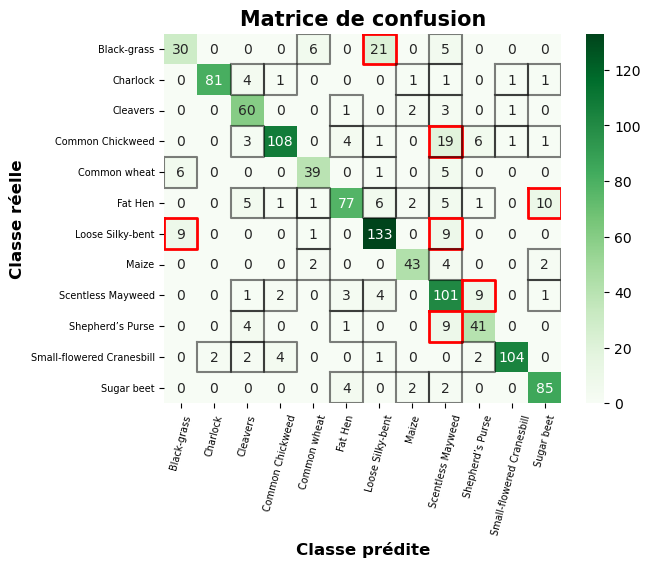

In [29]:
# Rapport de classification et matrice de confusion
def show_metrics(y_test, test_pred_class):
    
    #Evaluation du modèle : rapport de classification & matrice de confusion
    print(classification_report(y_test, test_pred_class, target_names = df.species.unique()))

    matrix = confusion_matrix(y_test, test_pred_class)
    classes = df.species.unique()

    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd')
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)

    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)


    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)

    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);
    
show_metrics(y_test, test_pred_class)

In [13]:
# Importer le meilleur entrainement
from keras import models
from keras.models import load_model   
loadweights_filepath = Path('Models_training','MobileNetV2_SansSeg_SansZoom','Freeze','best_weights.ckpt')
model.load_weights(loadweights_filepath)

In [14]:
# Evaluation du modèle
lr=1.e-3
model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics='accuracy')
res_train = model.evaluate(train_iterator)
res_valid = model.evaluate(validation_iterator)
res_test = model.evaluate(test_iterator)

35/35 [==============================] - 10s 293ms/step - loss: 0.5346 - accuracy: 0.8141
